# Activated Labours: data analysis and time series
The purpose of this notebook is to have an initial view of the data contained in the **Rapporti_di_lavoro_attivati**.
The objective of this study is to have an initial understanding of eventually founded trends over number of activated labours during the past time.
Next steps will be to add more deep analysis about time and some particular features that are present in the dataset. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import utils

STD_SIZE = (15, 10)
MID_SIZE = (25, 20)
BIG_SIZE = (30, 30)

/home/ale/anaconda3/envs/datasciencefb/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


### Study on dataset **Activated Labours**

In [2]:
!ls

analysis_activated_labours.ipynb  readme.md
ceased_labours.ipynb		  requirements.txt
__pycache__			  transformations_activated_labours.ipynb
Rapporti_di_lavoro_attivati.csv   utils.py
Rapporti_di_lavoro_cessati.csv


In [3]:
activated_labours = pd.read_csv('Rapporti_di_lavoro_attivati.csv', parse_dates=['DATA'])
print(f'Shape: {activated_labours.shape}')
activated_labours.head()

Shape: (9579794, 9)


DATA GENERE  ETA                          SETTOREECONOMICODETTAGLIO  \
0 2020-09-05      F   60  Attività di famiglie e convivenze come datori ...   
1 2019-12-07      M   43  Gestioni di funicolari, ski-lift e seggiovie s...   
2 2013-05-06      F   20  Fabbricazione di altre apparecchiature elettri...   
3 2010-12-03      F   28                                           Alberghi   
4 2021-06-04      F   49                                 Rifugi di montagna   

                                        TITOLOSTUDIO  \
0                            NESSUN TITOLO DI STUDIO   
1                                      LICENZA MEDIA   
2                                      LICENZA MEDIA   
3  DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CH...   
4                                      LICENZA MEDIA   

                                           CONTRATTO MODALITALAVORO  \
0                                   LAVORO DOMESTICO    TEMPO PIENO   
1                         LAVORO A TEMPO DETERMINATO    TEMPO PIENO   
2  APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...    TEMPO PIENO   
3           LAVORO INTERMITTENTE A TEMPO DETERMINATO   NON DEFINITO   
4                               LAVORO INTERMITTENTE   NON DEFINITO   

  PROVINCIAIMPRESA ITALIANO  
0          BERGAMO  UCRAINA  
1          BERGAMO   ITALIA  
2          BERGAMO   ITALIA  
3          BERGAMO   ITALIA  
4          BERGAMO   ITALIA

In [4]:
activated_labours.dtypes

DATA                         datetime64[ns]
GENERE                               object
ETA                                   int64
SETTOREECONOMICODETTAGLIO            object
TITOLOSTUDIO                         object
CONTRATTO                            object
MODALITALAVORO                       object
PROVINCIAIMPRESA                     object
ITALIANO                             object
dtype: object

In [5]:
len(activated_labours)

9579794

### Sort records basing on DATA column

Convert values into DATA column into datetime objects.
This step is mainly required for time series analysis started at the end of the notebook.

In [6]:
activated_labours['DATA'].head()

0   2020-09-05
1   2019-12-07
2   2013-05-06
3   2010-12-03
4   2021-06-04
Name: DATA, dtype: datetime64[ns]

Sort basing on dates

In [7]:
activated_labours = activated_labours.sort_values(by='DATA', ascending=True)
activated_labours.reset_index(drop=True, inplace=True)
min_ok = activated_labours.DATA.min() == activated_labours.DATA[0]
max_ok = activated_labours.DATA.max() == activated_labours.DATA[len(activated_labours) - 1]
print('Sorted' if min_ok and max_ok else 'Not sorted')

Sorted


## Inspection of null values

In [8]:
utils.missing_values_table(activated_labours)

Your selected dataframe has 9 columns.
There are 3 columns that have missing values.


Missing Values  % of Total Values
MODALITALAVORO                     440779                4.6
SETTOREECONOMICODETTAGLIO            2888                0.0
TITOLOSTUDIO                          580                0.0

Only three columns contains null values... Let's inspect more deeply how could i remove them.

### TITOLO DI STUDIO

In [9]:
activated_labours.loc[:, ['TITOLOSTUDIO']].value_counts()

TITOLOSTUDIO                                                                                                           
NESSUN TITOLO DI STUDIO                                                                                                    2721891
LICENZA MEDIA                                                                                                              2523342
DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L'ACCESSO ALL'UNIVERSITA                                          2430781
LAUREA - Vecchio o nuovo ordinamento                                                                                        988171
TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCOLASTICA ED EXTRA-SCOLASTICA) CHE NON PERMETTE L'ACCESSO ALL'UNIVERSITÀ ()     645228
LICENZA ELEMENTARE                                                                                                           82570
DIPLOMA UNIVERSITARIO                                                                         

I'll fill in all the null values in the **TITOLO DI STUDIO** column with the **NESSUN TITOLO DI STUDIO** value

In [10]:
activated_labours.TITOLOSTUDIO.fillna('NESSUN TITOLO DI STUDIO', inplace=True)

In [11]:
utils.missing_values_table(activated_labours)

Your selected dataframe has 9 columns.
There are 2 columns that have missing values.


Missing Values  % of Total Values
MODALITALAVORO                     440779                4.6
SETTOREECONOMICODETTAGLIO            2888                0.0

### SETTORE ECONOMICO DETTAGLIO

In [12]:
counts = activated_labours.loc[:, ['SETTOREECONOMICODETTAGLIO']].value_counts()
counts

SETTOREECONOMICODETTAGLIO                                                                                                                                                      
Alberghi                                                                                                                                                                           467057
Ristorazione con somministrazione                                                                                                                                                  445191
Attività di produzione cinematografica, di video e di programmi televisivi                                                                                                         379116
Attività di famiglie e convivenze come datori di lavoro per personale domestico                                                                                                    348181
Altri servizi di supporto alle imprese nca                                      

<BarContainer object of 18 artists>

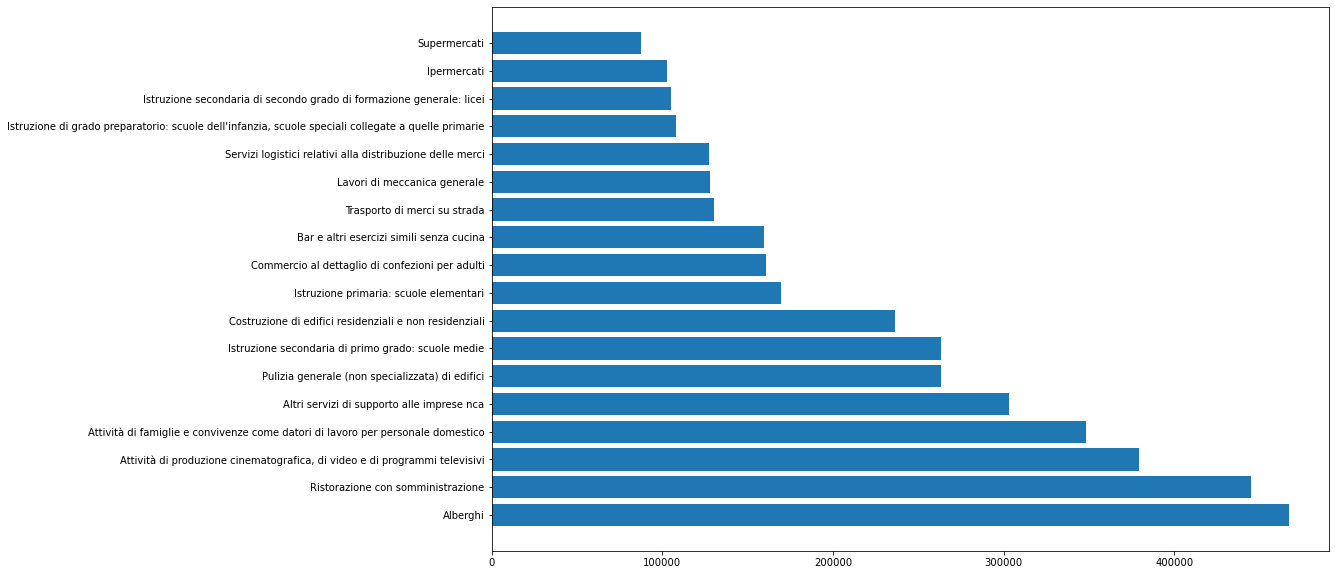

In [13]:
LIMIT = 80000
counts = counts[counts.values > LIMIT]
plt.figure(figsize=STD_SIZE)
plt.barh(y=[i[0] for i in counts.index], width=counts.values)

Column **settore economico dettaglio** contains too general information and not enough useful concerning our study. In order to make an understandable plot i would have to avoid considering too many values, so for now i'll drop it.

In [14]:
activated_labours.drop(labels=['SETTOREECONOMICODETTAGLIO'], axis=1, inplace=True)

In [15]:
utils.missing_values_table(activated_labours)

Your selected dataframe has 8 columns.
There are 1 columns that have missing values.


Missing Values  % of Total Values
MODALITALAVORO          440779                4.6

### MODALITA LAVORO

In [16]:
activated_labours.loc[:, ['MODALITALAVORO']].value_counts()

MODALITALAVORO            
TEMPO PIENO                   5337940
TEMPO PARZIALE ORIZZONTALE    2026056
NON DEFINITO                  1087460
TEMPO PARZIALE MISTO           445419
TEMPO PARZIALE VERTICALE       242140
dtype: int64

Fill null values into **modalità lavoro** with value **NON DEFINITO**

In [17]:
activated_labours['MODALITALAVORO'] = activated_labours['MODALITALAVORO'].fillna('NON DEFINITO')
activated_labours['MODALITALAVORO'].isnull().sum()

0

In [18]:
utils.missing_values_table(activated_labours)

Your selected dataframe has 8 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Now the dataframe contains **0** null values.

### Rename column **italiano** into **nazionalita**

In [19]:
activated_labours.rename({'ITALIANO': 'NAZIONALITA'}, axis=1, inplace=True)

# Duplicated records

In [20]:
activated_labours.duplicated().sum()

2536002

the presence of duplicated lines is not meaningful because there could be different people with same characteristics having activated a labour in the same day

## Descriptive statistics

The following function prints some useful measures of variability in order to have a clearer understanding of the **ETA** column, which is the only column that contains numerical values.

In [21]:
utils.variability_measures(activated_labours, column='ETA', limit=0.1)

Mean on column ETA: 35.301741457070996
Median on column ETA: 34.0
Mode on column ETA: 0    25
Name: ETA, dtype: int64
Variance on column ETA: 138.82357821373805
Standard deviation on column ETA: 11.78234179667769
Trimmed mean on column ETA with limit 0.1: 34.23565773871471
Mean absolute deviation on column ETA: 9.849852522936677
Median absolute deviation on column ETA: 9.768722688608962


### Plot of categorical data distributions

['GENERE', 'TITOLOSTUDIO', 'CONTRATTO', 'MODALITALAVORO', 'PROVINCIAIMPRESA', 'NAZIONALITA']


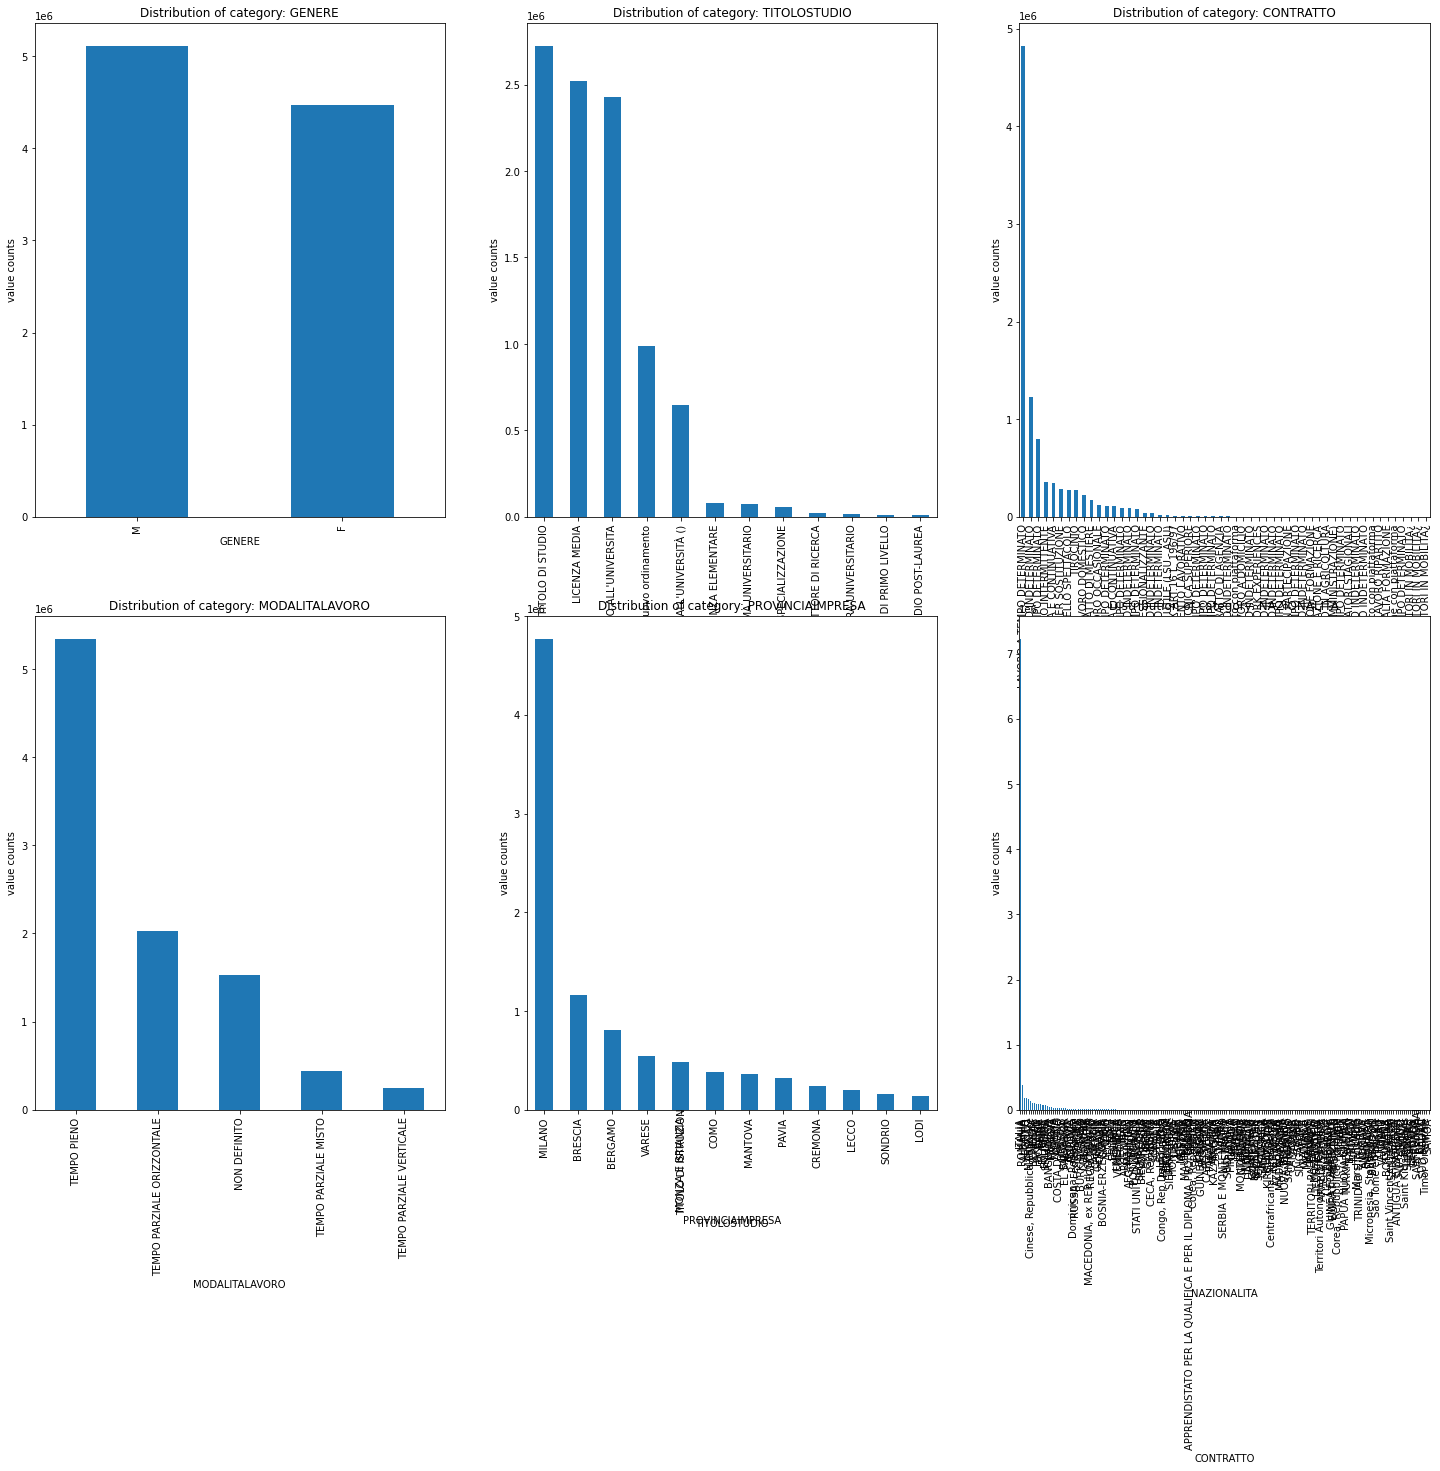

In [22]:
categorical_features = [col for col in activated_labours if activated_labours[col].dtype == 'object']
print(categorical_features)

fig = plt.figure(figsize=MID_SIZE)
for i, category in enumerate(categorical_features):
    ax = fig.add_subplot(2, 3, i+1)
    freqs = activated_labours[category].value_counts()
    freqs.plot.bar(x=freqs.index, y=freqs.values)
    ax.set_title('Distribution of category: %s' % category)
    ax.set_xlabel(category)
    ax.set_ylabel('value counts')
plt.show()

### Plot of numerical data distribution

In [23]:
activated_labours.ETA[activated_labours.ETA > 100]

76879      101
9579793    221
Name: ETA, dtype: int64

I remove the person that has 221 years

In [24]:
activated_labours = activated_labours[activated_labours.ETA != 221]
activated_labours.ETA.max()

101

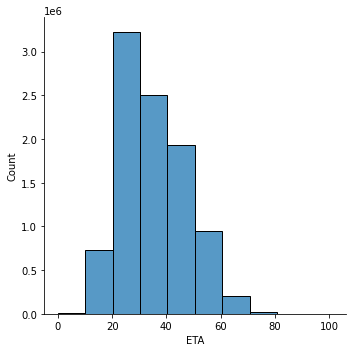

In [25]:
sns.displot(activated_labours.ETA, bins=10)

In [26]:
activated_labours.to_csv('./activated_labours_cleaned.csv')